Для данной лабораторной работы был выбран датасет от Intel в котором изображения разделены на 6 классов:
1. Buildings - постройки
2. Forests - леса
3. Glacier - ледники
4. Streets - улицы
5. Mountains - горы
6. Sea - моря

Задача состоит в классификации изображений по данный 6 классам.

Сначала обозначим пути к файлам и папка для обучения и валидации.

In [ ]:
import os, shutil

base_dir =  "C:/Users/mi-sh/OneDrive/Desktop/images"

train_dir = os.path.join(base_dir, 'seg_train')

validation_dir = os.path.join(base_dir, 'seg_test')

test_dir = os.path.join(base_dir, 'seg_pred', )

train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')

val_buildings_dir = os.path.join(validation_dir, 'buildings')
val_forest_dir = os.path.join(validation_dir, 'forest')
val_glacier_dir = os.path.join(validation_dir, 'glacier')
val_mountain_dir = os.path.join(validation_dir, 'mountain')
val_sea_dir = os.path.join(validation_dir, 'sea')
val_street_dir = os.path.join(validation_dir, 'street')





In [ ]:
print('total training buildings images:', len(os.listdir(train_buildings_dir)))
print('total training forest images:', len(os.listdir(train_forest_dir)))
print('total training glacier images:', len(os.listdir(train_glacier_dir)))
print('total training mountain images:', len(os.listdir(train_mountain_dir)))
print('total training sea images:', len(os.listdir(train_sea_dir)))
print('total training street images:', len(os.listdir(train_street_dir)), '\n')

print('total validation buildings images:', len(os.listdir(val_buildings_dir)))
print('total validation forest images:', len(os.listdir(val_forest_dir)))
print('total validation glacier images:', len(os.listdir(val_glacier_dir)))
print('total validation mountain images:', len(os.listdir(val_mountain_dir)))
print('total validation sea images:', len(os.listdir(val_sea_dir)))
print('total validation street images:', len(os.listdir(val_street_dir)),  '\n')

print('total test images:', len(os.listdir(test_dir)))

total training buildings images: 2191
total training forest images: 2271
total training glacier images: 2404
total training mountain images: 2512
total training sea images: 2274
total training street images: 2382 

total validation buildings images: 437
total validation forest images: 474
total validation glacier images: 553
total validation mountain images: 525
total validation sea images: 510
total validation street images: 501 

total test images: 7301


Как видно из данных выше, в среднем в тренировочной выборке примерно по 2400 изображений каждого класса, а в валидационной выборке примерно по 500. Далее построим первую модель сверточной нейронной сети. Для этого воспользуемся функцией активации softmax, так как у нас многоклассовая активация, а функцию потерь возьмем categorical_crossentropy.

Данная нейронная сеть состоит и 4 сверточных слоев, на которых происходит свертка, а также из 4 пулинговых слоев, которые уплотняют наше изображения. Данные слои последовательно чередуются между собой.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu',
                        input_shape=(150,150,3)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
 optimizer=optimizers.RMSprop(lr=1e-4),
 metrics=['acc'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
 validation_dir,
 target_size=(150, 150),
 batch_size=20,
 class_mode='categorical'
 )


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Таким образом, суммарно в тренировочной выборке 14034 изображений принадлежащих к 6 классам, а также 3000 изображений принадлежащих к 6 классам в валидационной выборке.

train_datagen делает предобработку изображений с перемасштабированием.
В нашем случае размер изображений составляет 150 на 150 пикселей.

Также установим колбеки, в которых прописываем остановку после 2 эпох без улучшений, а также сохранений логов после каждой эпохи.

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='C:/Users/mi-sh/OneDrive/Desktop/logs2')
]

In [ ]:
history = model.fit(
 train_generator,
 epochs=20,
 validation_data=validation_generator,
 callbacks=my_callbacks)

Epoch 1/20
702/702 [==============================] - 253s 359ms/step - loss: 1.0799 - acc: 0.5866 - val_loss: 0.9513 - val_acc: 0.6347
Epoch 2/20
702/702 [==============================] - 248s 354ms/step - loss: 0.8141 - acc: 0.6959 - val_loss: 0.7724 - val_acc: 0.7150
Epoch 3/20
702/702 [==============================] - 250s 357ms/step - loss: 0.6934 - acc: 0.7447 - val_loss: 0.7410 - val_acc: 0.7290
Epoch 4/20
702/702 [==============================] - 251s 357ms/step - loss: 0.6134 - acc: 0.7787 - val_loss: 0.7726 - val_acc: 0.7270
Epoch 5/20
702/702 [==============================] - 252s 360ms/step - loss: 0.5547 - acc: 0.7990 - val_loss: 0.6532 - val_acc: 0.7717
Epoch 6/20
702/702 [==============================] - 252s 360ms/step - loss: 0.5037 - acc: 0.8158 - val_loss: 0.5466 - val_acc: 0.8093
Epoch 7/20
702/702 [==============================] - 246s 351ms/step - loss: 0.4624 - acc: 0.8339 - val_loss: 0.6802 - val_acc: 0.7637
Epoch 8/20
702/702 [============================

Как мы видим, наша модель достигла максимального значения на 8 эпохе и точность составила 84,13%. На графиках можно наблюдать процесс обучения сети на каждой из эпох. 

Сохраним данную модель, а также попробуем скорректировать некоторые параметры чтобы получить лучшие результаты.

In [ ]:
model.save('intel_images1.h5')

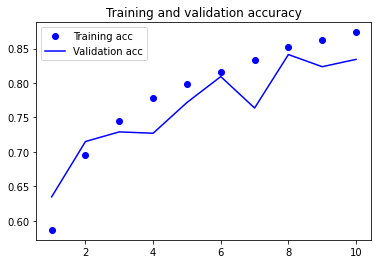

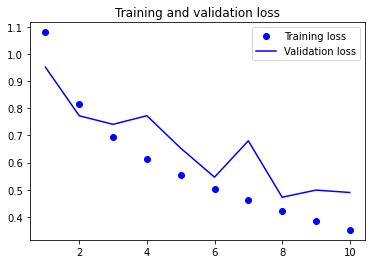

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Данная модель имеет аналогичную архитектуру, но на выходе имеет уменьшенное колиство каналов, за счет чего имеем меньшее количество параметров нейронной сети.

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3), activation='relu',
                        input_shape=(150,150,3)))

model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

In [ ]:
from keras import optimizers

model2.compile(loss='categorical_crossentropy',
 optimizer=optimizers.RMSprop(lr=1e-4),
 metrics=['acc'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
my_callbacks2 = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model2.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='C:/Users/mi-sh/OneDrive/Desktop/logs2_2')
]

In [ ]:
history2 = model2.fit(
 train_generator,
 epochs=20,
 validation_data=validation_generator,
 callbacks=my_callbacks2)

Epoch 1/20
702/702 [==============================] - 190s 269ms/step - loss: 1.1634 - acc: 0.5385 - val_loss: 0.9841 - val_acc: 0.6213
Epoch 2/20
702/702 [==============================] - 196s 280ms/step - loss: 0.9337 - acc: 0.6429 - val_loss: 0.8617 - val_acc: 0.6760
Epoch 3/20
702/702 [==============================] - 199s 283ms/step - loss: 0.8204 - acc: 0.6896 - val_loss: 0.8583 - val_acc: 0.6867
Epoch 4/20
702/702 [==============================] - 198s 281ms/step - loss: 0.7528 - acc: 0.7218 - val_loss: 0.7766 - val_acc: 0.7217
Epoch 5/20
702/702 [==============================] - 197s 281ms/step - loss: 0.6956 - acc: 0.7402 - val_loss: 0.6782 - val_acc: 0.7463
Epoch 6/20
702/702 [==============================] - 204s 290ms/step - loss: 0.6549 - acc: 0.7617 - val_loss: 0.7137 - val_acc: 0.7473
Epoch 7/20
702/702 [==============================] - 205s 292ms/step - loss: 0.6140 - acc: 0.7773 - val_loss: 0.6637 - val_acc: 0.7610
Epoch 8/20
702/702 [============================

В данном случае нейронная сеть достигла максимума на 13 эпохе и ее точность составила 82,27%, что ниже чем было ранее. Также процесс обучения закончился на 15 эпохе. Аналогично графики обучения представлены ниже.

In [ ]:
model2.save('intel_images2.h5')

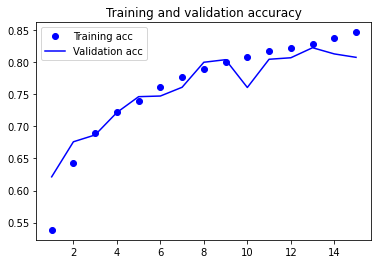

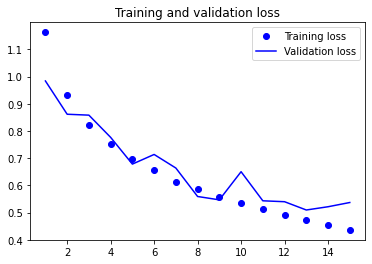

In [ ]:
import matplotlib.pyplot as plt
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Попробуем изменить архитектуру нейронной сети путем добавления в нее слоя GlobalAveragePooling2D, который усредняет значения по каналам. В данном случае мы наоборот увеличиваем количество каналов, чтобы получить достаточное количество параметров на выходе.

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32,(3,3), activation='relu',
                        input_shape=(150,150,3)))

model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(6, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
my_callbacks3 = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model3.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='C:/Users/mi-sh/OneDrive/Desktop/logs2_3')
]

In [ ]:
model3.compile(loss='categorical_crossentropy',
 optimizer=optimizers.RMSprop(lr=1e-4),
 metrics=['acc'])

In [ ]:
history3 = model3.fit(
 train_generator,
 epochs=20,
 validation_data=validation_generator,
 callbacks=my_callbacks3)

Epoch 1/20
702/702 [==============================] - 260s 369ms/step - loss: 1.3056 - acc: 0.4475 - val_loss: 1.1290 - val_acc: 0.5420
Epoch 2/20
702/702 [==============================] - 274s 391ms/step - loss: 1.0583 - acc: 0.5869 - val_loss: 0.9399 - val_acc: 0.6287
Epoch 3/20
702/702 [==============================] - 257s 366ms/step - loss: 0.9265 - acc: 0.6428 - val_loss: 0.9042 - val_acc: 0.6503
Epoch 4/20
702/702 [==============================] - 260s 370ms/step - loss: 0.8544 - acc: 0.6797 - val_loss: 0.8489 - val_acc: 0.6813
Epoch 5/20
702/702 [==============================] - 262s 374ms/step - loss: 0.8026 - acc: 0.6987 - val_loss: 0.8273 - val_acc: 0.6837
Epoch 6/20
702/702 [==============================] - 269s 383ms/step - loss: 0.7564 - acc: 0.7210 - val_loss: 0.7143 - val_acc: 0.7343
Epoch 7/20
702/702 [==============================] - 276s 393ms/step - loss: 0.7209 - acc: 0.7372 - val_loss: 0.6589 - val_acc: 0.7617
Epoch 8/20
702/702 [============================

В отличии от предыдущих примеров, нейронная сеть полность прошла все 20 эпох и ее максимальный результат составил 82,67%, что лучше чем в предыдущей нейронной сети, но хуже чем в первом варианте. В данной нейронной сети процесс обучения происходил плавнее чем в предыдущей архитектуре. Аналогично графики представлены и сохранена модель.

In [ ]:
model3.save('intel_images3.h5')

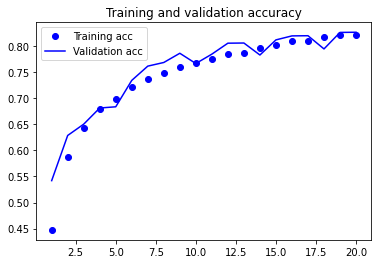

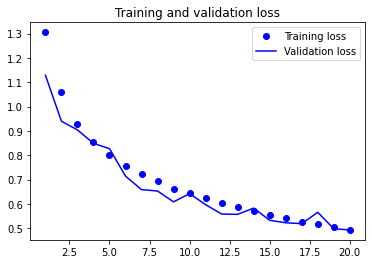

In [ ]:
import matplotlib.pyplot as plt
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Проведем проверку на тестовой выборке, для этого воспользуемся методом evaluate.

In [1]:
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
from keras import optimizers
from keras.utils import load_img

В качестве примера возьмем самую превую модель, которая дала наибольший результат. Для провекри воспользуемся 30 изображениями, которые относятся к 6 классам, по 5 изображений в каждом классе.

In [12]:
model=load_model('intel_images.h5')

In [13]:
predict_dir = os.path.join('C:/Users/mi-sh/OneDrive/Desktop/images/test')
img_width, img_height = 150, 150
datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
predict_generator = datagen.flow_from_directory(
    predict_dir,
    target_size=(150, 150),
    batch_size=20,
    )

Found 30 images belonging to 6 classes.


In [16]:
result = model.evaluate(predict_generator)

2/2 [==============================] - 0s 48ms/step - loss: 1.3300 - acc: 0.7333


Таким образом, наша модель дала на тестовой выборки точность в 73,3%, что ниже чем на валидационной првоерке.

